In [135]:
from typing import Tuple

import h5py
import numpy as np
import utils
from numpy.linalg import pinv

In [175]:
class Lab06_op:

    def load_data(self, dpath="data_brain_8coils.mat"):
        mat = utils.load_data(dpath)
        kdata = mat["d"]
        sens_maps = mat["c"]
        noise_maps = mat["n"]
        psi = np.cov(noise_maps.T)

        self.set_self(kdata)

        return kdata, sens_maps, noise_maps, psi

    def set_self(self, kdata):
        self.PE, self.RO, self.nCoil = kdata.shape

    def load_SESNE(self, R, dpath=None):
        if dpath is None:
            dpath = utils._get_root() / "SENSE_recons.h5"

        with h5py.File(dpath, "r") as f:
            sense_recon = f[f"SENSE_R{R}"][...]

        return sense_recon

    def get_acs(self, kdata: np.ndarray, nACS: int) -> np.ndarray:
        """
        Get ACS from the kspace

        @param kdata:       The kspace data [PE, RO, nCoil]
        @param nACS:        The number of ACS lines

        @return: acs:       The auto-calibration signal [nACS, RO, nCoil]
        """
        # Your code here ...
        PE = np.shape(kdata)[0]
        lower = int((PE-nACS)//2)
        upper = lower + nACS
        acs = kdata[lower:upper,:,:]
        return acs

    def get_block_h(self, kernel_size: Tuple[int, int], R: int) -> int:
        """
        Get the height of the GRAPPA block

        @param kernel_size:     The GRAPPA kernel size, Union[(2, 3), (4, 5), (6, 7)]
        @param R:               The acceleration factor

        @return:                The height of the block
        """
        # Your code here ...
        m,n = kernel_size
        return int(R * (m-1) + 1)

    def get_block_w(self, kernel_size: Tuple[int, int]) -> int:
        """
        Get the width of the GRAPPA block

        @param kernel_size:     The GRAPPA kernel size, Union[(2, 3), (4, 5), (6, 7)]

        @return:                The width of the block
        """
        # Your code here ...
        m,n = kernel_size
        return int(n)

    def get_n_b(self, nACS: int, kernel_size: Tuple[int, int], R: int, **kwargs) -> int:
        """
        Get the number of blocks in the ACS

        @param nACS:            The number of ACS lines
        @param kernel_size:     The GRAPPA kernel size, Union[(2, 3), (4, 5), (6, 7)]
        @param R:               The acceleration factor

        @return: n_b:           The number of blocks in the ACS
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        get_block_h = kwargs.get("get_block_h", self.get_block_h)
        get_block_w = kwargs.get("get_block_w", self.get_block_w)

        # Your code here ...
        window_w = self.RO ##########################################################****************************************************###############
        block_h = get_block_h(kernel_size,R)
        block_w = get_block_w(kernel_size)
        kernel_h, kernel_w = kernel_size
        n_b = (nACS - block_h + 1) * (window_w - block_w + 1)
        return int(n_b)

    def get_n_kc(self, kernel_size: Tuple[int, int]) -> int:
        """
        Get n_k * n_c. This is the number of coils times that of kernel size

        @param kernel_size:     The GRAPPA kernel size, Union[(2, 3), (4, 5), (6, 7)]

        @return: n_kc:          The number of coils and kernel size, n_kc in the lecture slides
        """
        # Your code here ...
        m,n = kernel_size
        n_kc = m * n * self.nCoil ####################################################################
        return int(n_kc)

    def extract(
        self, acs: np.ndarray, nACS: int, kernel_size: Tuple[int, int], R: int, **kwargs
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Extract source and target points from ACS

        @param acs:             The auto-calibration signal [nACS, RO, nCoil]
        @param nACS:            The number of ACS lines
        @param kernel_size:     The GRAPPA kernel size, Union[(2, 3), (4, 5), (6, 7)]
        @param R:               The acceleration factor

        @return:
            src :               source points [n_b x n_kc]
            targ:               target points [R-1 x n_b x nCoil]
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        get_n_b = kwargs.get("get_n_b", self.get_n_b)
        get_n_kc = kwargs.get("get_n_kc", self.get_n_kc)
        get_block_h = kwargs.get("get_block_h", self.get_block_h)

        # Your code here ...
        n_b = get_n_b(nACS,kernel_size,R)
        n_kc = get_n_kc(kernel_size)
        block_h = get_block_h(kernel_size, R)
        kernel_h, kernel_w = kernel_size

        src = np.zeros([n_b,n_kc], dtype=complex)
        num_vertical_blocks = nACS - block_h + 1
        num_horizontal_blocks = int(n_b / num_vertical_blocks) 
        for i in range(n_b):
            block_pos_ver = int (i/num_horizontal_blocks)
            block_pos_hor = i % num_horizontal_blocks
            #print(block_pos_ver, block_h, R, block_pos_hor,kernel_w)
            temp = acs[block_pos_ver:block_pos_ver + block_h:R, block_pos_hor:block_pos_hor+kernel_w,:]
            temp = np.resize(temp,[1,n_kc])
            src[i] = temp 

        n_coils = np.shape(acs)[2]
        targ = np.zeros([R-1,n_b,n_coils],dtype=complex)
        for i in range(R-1):
            for j in range(n_b):
                block_pos_ver = int (i/num_horizontal_blocks)
                block_pos_hor = i % num_horizontal_blocks
                hor_pos = block_pos_hor + int (kernel_w / 2)
                ver_pos = int(block_pos_ver + (kernel_h / 2 - 1) * R + i )
                temp = acs[ver_pos,hor_pos,:]
                temp = np.resize(temp,[1,n_coils])
                targ[i,j] = temp

        return src, targ

    def get_weights(self, src: np.ndarray, targ: np.ndarray) -> np.ndarray:
        """
        Get the weights for GRAPPA reconstruction.
        Use pinv function from numpy.linalg to get the pseudo-inverse.
        Use @ operator for matrix multiplication.

        @param src:         The source points [n_b x n_kc]
        @param targ:        The target points [R-1 x n_b x nCoil]

        @return:            The weights for GRAPPA reconstruction [R-1, n_kc, nCoil]
        """
        # Your code here ...
        n_b, n_kc = np.shape(src)
        R = np.shape(targ)[0] + 1
        nCoil = np.shape(targ)[2]

        weights = np.zeros([R-1, n_kc, nCoil],dtype=complex)
        for i in range(R-1):
            weights[i] = pinv(src) @ targ[i]
        return weights

    def get_mask(self, kdata: np.ndarray, R: int) -> np.ndarray:
        """
        Get undersampling mask, which keeps the original size, by taking every R-th line in the PE direction.
        Start to take the first line.

        @param kdata:       The kspace data [PE, RO, nCoil]
        @param R:           The acceleration factor

        @return:            Undersampling mask [PE, RO, nCoil]
        """
        # Your code here ...

        PE, RO, nCoil = np.shape(kdata)
        ones = np.ones([1,RO],dtype=complex)
        m = np.zeros([PE,1],dtype=complex)
        for i in range(PE):
            if i % R == 0:
                m[i] = 1
        temp = m @ ones
        mask = np.zeros_like(kdata,dtype=complex)
        for i in range(nCoil):
            mask[:,:,i] = temp 
        return mask

    def undersample(self, kdata: np.ndarray, R: int, acs: np.ndarray, nACS: int, **kwargs) -> np.ndarray:
        """
        Undersample the kdata along the PE direction while keeping the original size and the ACS.
        Apply the undersampling mask to the kdata and fill the ACS lines with the ACS data.

        @param kdata:       kdata [PE, RO, nCoil]
        @param R:           The acceleration factor
        @param acs:         The auto-calibration signal [nACS, RO, nCoil]
        @param nACS:        The number of ACS lines

        @return:            Undersampled kdata [PE, RO, nCoil]
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        get_mask = kwargs.get("get_mask", self.get_mask)

        # Your code here ...
        undersampled = get_mask(kdata,R) * kdata

        PE = np.shape(kdata)[0]
        lower = int((PE-nACS)//2)
        upper = lower + nACS
        undersampled[lower:upper,:,:] = kdata[lower:upper,:,:]

        return undersampled

    def get_pad_PE_up(self, kernel_PE: int, R: int) -> int:
        """
        Get the padding size for the PE direction (up)

        @param kernel_PE:       The PE size of the kernel
        @param R:               The acceleration factor

        @return:                The padding size
        """
        # Your code here ...
        return int(R*(kernel_PE/2 -1))

    def get_pad_PE_down(self, kernel_PE: int, R: int) -> int:
        """
        Get the padding size for the PE direction (down)

        @param kernel_PE:       The PE size of the kernel
        @param R:               The acceleration factor

        @return:                The padding size
        """
        # Your code here ...
        rem = (self.PE - 1) % R
        if rem == 0:
            return int(R*(kernel_PE/2 -1))
        
        else:
            return int(R*(kernel_PE/2)) - rem 

    def get_pad_RO_left(self, kernel_RO: int) -> int:
        """
        Get the padding size for the RO direction (left)

        @param kernel_RO:       The RO size of the kernel

        @return:                The padding size of the left readout direction
        """
        # Your code here ...
        return int(kernel_RO/2)

    def get_pad_RO_right(self, kernel_RO: int) -> int:
        """
        Get the padding size for the RO direction (right)

        @param kernel_RO:       The RO size of the kernel

        @return:                The padding size of the right readout direction
        """
        # Your code here ...
        return int (kernel_RO/2)

    def zero_padding(self, input_k: np.ndarray, kernel_size: Tuple[int, int], R: int, **kwargs) -> np.ndarray:
        """
        Zero padding for interpolation using kernels

        @param input_k:         Input kdata [PE, RO, nCoil]
        @param kernel_size:     The GRAPPA kernel size, Union[(2, 3), (4, 5), (6, 7)]
        @param R:               Acceleration factor

        @return:
            zp_kdata:           Zero-padded kspace [PE + pad_PE_up + pad_PE_down, RO + pad_RO_left + pad_RO_right, nCoil]
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        get_pad_PE_up = kwargs.get("get_pad_PE_up", self.get_pad_PE_up)
        get_pad_PE_down = kwargs.get("get_pad_PE_down", self.get_pad_PE_down)
        get_pad_RO_left = kwargs.get("get_pad_RO_left", self.get_pad_RO_left)
        get_pad_RO_right = kwargs.get("get_pad_RO_right", self.get_pad_RO_right)

        # Your code here ...
        PE, RO, nCoil = np.shape(input_k)
        kernel_h, kernel_w = kernel_size
        pad_up, pad_down = get_pad_PE_up(kernel_h,R), get_pad_PE_down(kernel_h, R)
        pad_left, pad_right = get_pad_RO_left(kernel_w), get_pad_RO_right(kernel_w)
        zp_kdata = np.zeros([pad_up + PE + pad_down, pad_left + RO + pad_right, nCoil],dtype=complex)
        zp_kdata[pad_up : pad_up + PE, pad_left : pad_left + RO, :] = input_k

        return zp_kdata

    def grappa_core(
        self, kdata_us: np.ndarray, weights: np.ndarray, kernel_size: Tuple[int, int], R: int, **kwargs
    ) -> np.ndarray:
        """
        This method interpolates missing kdata coefficients using the GRAPPA weights

        @param kdata_us:        The undersampled kspace data [PE, RO, nCoil]
        @param weights:         The GRAPPA weights [R-1, n_kc, nCoil]
        @param kernel_size:     The GRAPPA kernel size, Union[(2, 3), (4, 5), (6, 7)]
        @param R:               The acceleration factor

        @return:                The GRAPPA reconstructed kspace [PE + pad_PE_up + pad_PE_down, RO + pad_RO_left + pad_RO_right, nCoil]
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        get_block_h = kwargs.get("get_block_h", self.get_block_h)
        zero_padding = kwargs.get("zero_padding", self.zero_padding)

        # Your code here ...
        block_h = get_block_h(kernel_size,R)
        padded_kdata = zero_padding(kdata_us,kernel_size,R)
        extrapolated_kdata = np.zeros_like(padded_kdata)
        padded_kdata_h, padded_kdata_w, nCoils = np.shape(padded_kdata)
        kernel_h, kernel_w = kernel_size
        for i in range((padded_kdata_h - block_h)//R):
            for j in range(padded_kdata_w - (kernel_w // 2)):
                for k in range(1,R):
                    targ_row_pos = i*R + R * (kernel_h // 2 -1) + k 
                    targ_col_pos = j + (kernel_w // 2)
                    current_weight = weights[k-1]
                    current_src = padded_kdata[i*R : (i+kernel_h)*R : R , j : j+kernel_w , :]
                    current_src = np.resize(current_src,[1,kernel_h*kernel_w*nCoils])
                    #print(np.shape(current_src), np.shape(current_weight))
                    temp = current_src @ current_weight
                    extrapolated_kdata[targ_row_pos,targ_col_pos,:] = temp 

        grappa_k = extrapolated_kdata
        return grappa_k

    def crop2original(self, padded_input_k: np.ndarray, kernel_size: Tuple[int, int], R: int, **kwargs) -> np.ndarray:
        """
        Crop the padded kspace to its original size

        @param padded_input_k:      Padded kspace [PE + pad_PE_up + pad_PE_down, RO + pad_RO_left + pad_RO_right, nCoil]
        @param kernel_size:         The GRAPPA kernel size, Union[(2, 3), (4, 5), (6, 7)] **##### kernel size is always even * odd
        @param R:                   Acceleration factor

        @return:                    Cropped kspace [PE, RO, nCoil]
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        get_pad_PE_up = kwargs.get("get_pad_PE_up", self.get_pad_PE_up)
        get_pad_RO_left = kwargs.get("get_pad_RO_left", self.get_pad_RO_left)

        # Your code here ...
        kernel_h, kernel_w = kernel_size
        pad_up, pad_left = self.get_pad_PE_up(kernel_h, R), self.get_pad_RO_left(kernel_w)
        resized_output = padded_input_k[pad_up : pad_up + self.PE, pad_left : pad_left + self.RO]
        return resized_output

    def data_consistency(self, input_k: np.ndarray, kdata_us: np.ndarray) -> np.ndarray:
        """
        Data consistency step for GRAPPA.
        This method keep the original signal from the undersampled kspace and fill only the missing coefficients with the GRAPPA reconstructed kspace

        @param input_k:         GRAPPA reconstructed kspace [PE, RO, nCoil]
        @param kdata_us:        Undersampled kspace [PE, RO, nCoil]

        @return:                GRAPPA reconstructed kspace with the original signal [PE, RO, nCoil]
        """
        # Your code here ...
        dc_k = np.copy(input_k)
        PE = np.shape(input_k)[0]
        for i in range(PE):
            if np.sum(kdata_us[i]) != 0:
                dc_k[i] = kdata_us[i]     

        return dc_k

    def run_grappa(self, kdata: np.ndarray, nACS: int, kernel_size: Tuple[int, int], R: int) -> np.ndarray:
        """
        Running GRAPPA algorithm for the undersampled kdata at the acceleration factor R
        The GRAPPA algorithm is applyed with nACS ACS lines and kernel size.

        @param kdata:           The kspace data [PE, RO, nCoil]
        @param nACS:            The number of ACS lines
        @param kernel_size:     The GRAPPA kernel size, Union[(2, 3), (4, 5), (6, 7)]
        @param R:               The acceleration factor

        @return:                GRAPPA reconstructed kspace [PE, RO, nCoil]
        """
        acs = self.get_acs(kdata, nACS)
        src, targ = self.extract(acs, nACS, kernel_size, R)
        weights = self.get_weights(src, targ)

        kdata_us = self.undersample(kdata, R, acs, nACS)

        grappa_k_zp = self.grappa_core(kdata_us, weights, kernel_size, R)
        grappa_k_cropped = self.crop2original(grappa_k_zp, kernel_size, R)
        grappa_k = self.data_consistency(grappa_k_cropped, kdata_us)

        return grappa_k



In [185]:
op = Lab06_op()
kdata, sens_maps, noise_maps, psi = op.load_data()

nACS = 32
kernel_size = (4,5)
R = 3
acs = op.get_acs(kdata,nACS)

src,targ = op.extract(acs,nACS,kernel_size,R)
weights = op.get_weights(src,targ)

undsam1 = op.undersample(kdata,R,acs,nACS)
padded_kdata = op.zero_padding(kdata,kernel_size,R)
gcore = op.grappa_core(undsam1,weights,kernel_size,R)
print(np.shape(gcore))


print(gcore[125:130,128:135,3])
print()
print(undsam1[125:130,128:135,3])

cropped = op.crop2original(gcore,kernel_size,R)
consistent_kdata = op.data_consistency(cropped,undsam1)

(262, 260, 8)
[[ 0.02593357-0.02005688j  0.02101879-0.02508399j  0.02309569-0.01869549j
   0.02177478-0.02432584j  0.00421668-0.01353293j -0.00554206+0.00298454j
  -0.00039043-0.00283297j]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.01663489+0.01452517j  0.01939469+0.00808542j  0.01690093+0.01051171j
   0.02001885+0.00864812j  0.01055522+0.00521684j -0.00310288-0.00246109j
   0.00228169-0.00304663j]
 [ 0.03667203-0.01393047j  0.02888572-0.02363937j  0.03060392-0.0177025j
   0.03028944-0.02414727j  0.01700028-0.01218277j -0.00645126+0.00280597j
  -0.00286777-0.00612304j]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]]

[[-2.40560168-0.08350579j  0.16747657-0.26913876j  0.49912904+0.3265839j
  -0.52734033-0.09673075j -0.36904139-0.29862268j  0.12269991+0.16796

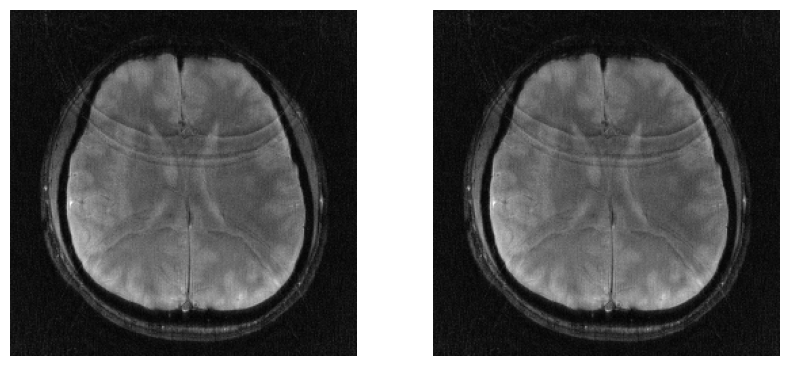

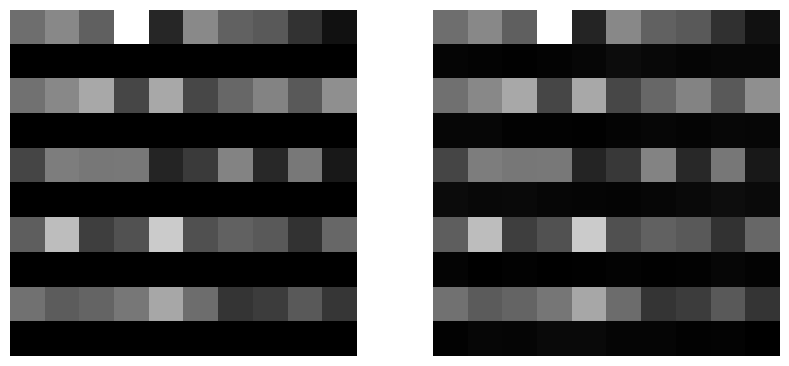

In [162]:

out = np.zeros_like(consistent_kdata,dtype=complex)
for i in range(np.shape(consistent_kdata)[2]):
    out[:,:,i] = utils.ifft2c(consistent_kdata[:,:,i])

m_squared = np.square(np.abs(out))
mc = np.sqrt(np.sum(m_squared,axis=-1))


out_undsamp = np.zeros_like(consistent_kdata,dtype=complex)
for i in range(np.shape(consistent_kdata)[2]):
    out_undsamp[:,:,i] = utils.ifft2c(undsam1[:,:,i])

m_squared_us = np.square(np.abs(out_undsamp))
mc_us = np.sqrt(np.sum(m_squared_us,axis=-1))

utils.imshow([mc,mc_us])
utils.imshow([undsam1[80:90,10:20,1],consistent_kdata[80:90,10:20,1]])
